In [69]:
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
import pickle
from calculateColumnsForModel import calculateColumnsForModel, getMedianOfCollectedData, numberToRoleName
from common_constants import PARTICIPANTS_NUMBER_OF_A_TEAM, RANGE_OF_RECENT_GAME, YEAR_DAYS, HALF_OF_YEAR_DAYS, STAT_MEDIAN_MULTIPLIER, SHRINKAGE_RATE
import joblib

In [55]:


participant_ids_by_role = []
team_Ids_list = []
DETAIL_PATH = "../data/collected_data/"

strcolumn_dict = {"tournamentId":"str", "matchId":"str", "gameId":"str", "patch":"str", "esportsTeamId_Blue":"str", "esportsTeamId_Red":"str"}
esportsPlayerIds_columns = [f"esportsPlayerId_{i}" for i in range(10)]
temp2 = ["str" for i in range(10)]
esportsPlayerId_type_dict = dict(zip(esportsPlayerIds_columns, temp2))
strcolumn_dict.update(esportsPlayerId_type_dict)
game_ids_df = pd.read_excel("../data/game_ids.xlsx", dtype=strcolumn_dict, index_col = 0)
#game_ids_df = pd.read_excel("../data/game_ids_for_test.xlsx", dtype=strcolumn_dict, index_col = 0)
strcolumn_dict = {"gameId":"str", "esportsTeamId_Blue":"str", "esportsTeamId_Red":"str"}
esportsPlayerId_type_dict = dict(zip(esportsPlayerIds_columns, temp2))
strcolumn_dict.update(esportsPlayerId_type_dict)
last_row_of_collected_datas_df = pd.read_excel("../data/last_row_of_collected_datas.xlsx", dtype = strcolumn_dict)
#last_row_of_collected_datas_df = pd.read_excel("../data/last_row_of_collected_datas_of_test.xlsx", dtype = strcolumn_dict)

#이거 넣어야 됨. id에 널값이 있는 게임은 누군지도 모르니까 걍 제외.
included_all_ids_df = game_ids_df[game_ids_df["esportsPlayerId_0"].notna() & game_ids_df["esportsPlayerId_1"].notna() & game_ids_df["esportsPlayerId_2"].notna() &\
                                  game_ids_df["esportsPlayerId_3"].notna() & game_ids_df["esportsPlayerId_4"].notna() & game_ids_df["esportsPlayerId_5"].notna() &\
                                    game_ids_df["esportsPlayerId_6"].notna() & game_ids_df["esportsPlayerId_7"].notna() & game_ids_df["esportsPlayerId_8"].notna() &\
                                        game_ids_df["esportsPlayerId_9"].notna()]

included_all_ids_df_sorted = included_all_ids_df.sort_values(by=["startTime(match)", "gameNumberInAMatch"], ascending=[False, False]).reset_index() # 최근 경기가 위로 오도록 내림차순 정렬

median_playerstat = getMedianOfCollectedData()
last_game_time = included_all_ids_df_sorted.iloc[0, :]["startTime(match)"]  # 가장 최근 경기한 시간. 여기서는 모델에 들어갈 기준 시간이 된다.



teamId_blue_ser = game_ids_df[pd.isna(game_ids_df["esportsTeamId_Blue"]) == False]["esportsTeamId_Blue"]
teamId_red_ser = game_ids_df[pd.isna(game_ids_df["esportsTeamId_Red"]) == False]["esportsTeamId_Red"]
team_Ids_list = list(set(pd.concat([teamId_blue_ser, teamId_red_ser], ignore_index=True)))          # 게임데이터에 나온 모든 팀들 리스트
#print(len(team_Ids_list))

for i in range(PARTICIPANTS_NUMBER_OF_A_TEAM):       # 탑 정글 미드 원딜 서폿 이렇게.. 포지션별
    playerId_blue_ser = game_ids_df[pd.isna(game_ids_df[f"esportsPlayerId_{i}"]) == False][f"esportsPlayerId_{i}"]  # 블루팀 플레이어id 시리즈
    playerId_red_ser = game_ids_df[pd.isna(game_ids_df[f"esportsPlayerId_{i + PARTICIPANTS_NUMBER_OF_A_TEAM}"]) == False][f"esportsPlayerId_{i + PARTICIPANTS_NUMBER_OF_A_TEAM}"]    # 레드팀 플레이어id 시리즈
    participant_ids_by_role.append(list(set(pd.concat([playerId_blue_ser,playerId_red_ser], ignore_index=True))))   # 블루팀 레드팀 상관없이 역할군에 참여한 플레이어들이 리스트에 append.

100%|██████████| 8036/8036 [07:50<00:00, 17.09it/s]


In [56]:

    
past_games_df = included_all_ids_df_sorted
team_history_dict = {}
player_form_dict = {}
ten_matches_duration = []
headtohead_ten_matches_duration = []
for team_id in tqdm(team_Ids_list):
    team_wincount = 1       # 데이터가 적을 때 극단적인 승률이 나오는 걸 방지하기 위해 가상의 1승 1패를 더하는데 그 중 1승 부분
    subrow_count = 0
    count = 0
    team_golddiff_sum = 0
    team_killdiff_sum = 0
    weight = 1
    target_games = past_games_df[(past_games_df["esportsTeamId_Blue"] == team_id) | (past_games_df["esportsTeamId_Red"] == team_id)]    # 블루팀에 있든 레드팀에 있든 상관없이
    for idx, row in target_games.iterrows():
        target_game_detail = last_row_of_collected_datas_df[last_row_of_collected_datas_df["gameId"] == row["gameId"]].T.squeeze()
        count += 1
        if count == 1:
            last_game_time_of_the_team = row["startTime(match)"]
        elif count == RANGE_OF_RECENT_GAME:
            ten_matches_duration.append((last_game_time_of_the_team - row["startTime(match)"]).days)
        subrow_count += weight
        if row["esportsTeamId_Blue"] == team_id:
            team_golddiff_sum += ((target_game_detail["blue_totalGold"] - target_game_detail["red_totalGold"]) / target_game_detail["duration"]) * weight
            team_killdiff_sum += ((target_game_detail["blue_totalKills"] - target_game_detail["red_totalKills"]) / target_game_detail["duration"]) * weight
            if row["winner_side"] == "Blue":
                team_wincount += weight
        elif row["esportsTeamId_Red"] == team_id:
            team_golddiff_sum += ((target_game_detail["red_totalGold"] - target_game_detail["blue_totalGold"]) / target_game_detail["duration"]) * weight
            team_killdiff_sum += ((target_game_detail["red_totalKills"] - target_game_detail["blue_totalKills"]) / target_game_detail["duration"]) * weight
            if row["winner_side"] == "Red":
                team_wincount += weight
        weight = weight * SHRINKAGE_RATE
    if count < RANGE_OF_RECENT_GAME:
        ten_matches_duration.append(0)
                
    team_winrate = team_wincount / (subrow_count + 2)   # 데이터가 적을 때 극단적인 승률이 나오는 걸 방지하기 위해 가상의 1승 1패를 더하는데 그 중 1패(정확히는 가상의 2전을 더하는) 부분
    if subrow_count == 0:                   # 0으로 나누는 걸 피하기 위한 코드
        team_golddiff = team_golddiff_sum
        team_killdiff = team_killdiff_sum
    else:
        team_golddiff = team_golddiff_sum / subrow_count
        team_killdiff = team_killdiff_sum / subrow_count
    if team_id not in team_history_dict:
        team_history_dict[team_id] = {}
    
    if "self" not in team_history_dict[team_id]:
        team_history_dict[team_id]["self"] = {}
    team_history_dict[team_id]["self"].update({"winrate": team_winrate})        # 다중 딕셔너리는 한번에 업데이트가 안 되는 걸까..?
    team_history_dict[team_id]["self"].update({"golddiff": team_golddiff})
    team_history_dict[team_id]["self"].update({"killdiff": team_killdiff})
    for opposite_team_id in team_Ids_list:
        particular_winrate_dict = {}
        if opposite_team_id == team_id:
            continue
        else:
            target_games = past_games_df[((past_games_df["esportsTeamId_Blue"] == team_id) & (past_games_df["esportsTeamId_Red"] == opposite_team_id)) |
                                        ((past_games_df["esportsTeamId_Red"] == team_id) & (past_games_df["esportsTeamId_Blue"] == opposite_team_id))
                                        ]
            particular_wincount = 1         # 데이터가 적을 때 극단적인 승률이 나오는 걸 방지하기 위해 가상의 1승 1패를 더하는데 그 중 1승 부분
            particular_subrow_count = 0
            particular_count = 0
            particular_golddiff_sum = 0
            particular_killdiff_sum = 0
            particular_weight = 1
            for idx, row in target_games.iterrows():
                target_game_detail = last_row_of_collected_datas_df[last_row_of_collected_datas_df["gameId"] == row["gameId"]].T.squeeze()
                particular_count += 1
                if particular_count == 1:
                    last_game_time_of_the_team = row["startTime(match)"]
                elif particular_count == RANGE_OF_RECENT_GAME:
                    headtohead_ten_matches_duration.append((last_game_time_of_the_team - row["startTime(match)"]).days)
                particular_subrow_count += particular_weight
                if ((row["esportsTeamId_Blue"] == team_id) & (row["esportsTeamId_Red"] == opposite_team_id)):
                    particular_golddiff_sum += ((target_game_detail["blue_totalGold"] - target_game_detail["red_totalGold"]) / target_game_detail["duration"]) * particular_weight
                    particular_killdiff_sum += ((target_game_detail["blue_totalKills"] - target_game_detail["red_totalKills"]) / target_game_detail["duration"]) * particular_weight
                    if (row["winner_side"] == "Blue"):
                        particular_wincount += particular_weight
                elif ((row["esportsTeamId_Red"] == team_id) & (row["esportsTeamId_Blue"] == opposite_team_id)):
                    particular_golddiff_sum += ((target_game_detail["red_totalGold"] - target_game_detail["blue_totalGold"]) / target_game_detail["duration"]) * particular_weight
                    particular_killdiff_sum += ((target_game_detail["red_totalKills"] - target_game_detail["blue_totalKills"]) / target_game_detail["duration"]) * particular_weight
                    if (row["winner_side"] == "Red"):
                        particular_wincount += particular_weight
                particular_weight = particular_weight * SHRINKAGE_RATE
            if particular_count > 0 and particular_count < RANGE_OF_RECENT_GAME:
                headtohead_ten_matches_duration.append(0)
            particular_winrate = particular_wincount / (particular_subrow_count + 2)    # 데이터가 적을 때 극단적인 승률이 나오는 걸 방지하기 위해 가상의 1승 1패를 더하는데 그 중 1패(정확히는 가상의 2전을 더하는) 부분
            if particular_subrow_count == 0:                                # 0으로 나누는걸 피하기 위한 코드.
                particular_golddiff = particular_golddiff_sum
                particular_killdiff = particular_killdiff_sum
            else:
                particular_golddiff = particular_golddiff_sum / particular_subrow_count
                particular_killdiff = particular_killdiff_sum / particular_subrow_count
            if team_id not in team_history_dict:
                team_history_dict[team_id] = {}
            
            if opposite_team_id not in team_history_dict[team_id]:
                team_history_dict[team_id][opposite_team_id] = {}
            team_history_dict[team_id][opposite_team_id].update({"winrate": particular_winrate})
            team_history_dict[team_id][opposite_team_id].update({"golddiff": particular_golddiff})
            team_history_dict[team_id][opposite_team_id].update({"killdiff": particular_killdiff})

  0%|          | 0/162 [00:00<?, ?it/s]

100%|██████████| 162/162 [03:28<00:00,  1.29s/it]


In [57]:
headtohead_ten_matches_duration.count(0)

1222

In [58]:
len(headtohead_ten_matches_duration)

1796

In [59]:
ten_matches_duration.count(0)

9

In [60]:
len(ten_matches_duration)

162

In [61]:
count_dict = {}
headtohead_count_dict = {}
for i in range(max(ten_matches_duration) + 1):
    if ten_matches_duration.count(i) != 0:
        count_dict.update({i:ten_matches_duration.count(i)})
for i in range(max(headtohead_ten_matches_duration) + 1):
    if headtohead_ten_matches_duration.count(i) != 0:
        headtohead_count_dict.update({i:headtohead_ten_matches_duration.count(i)})

In [62]:
print(count_dict)
print(count_dict.values)
print(headtohead_count_dict)

{0: 9, 1: 1, 3: 5, 4: 1, 6: 4, 7: 12, 8: 12, 9: 9, 10: 2, 11: 1, 12: 7, 13: 12, 14: 9, 15: 4, 16: 6, 18: 2, 19: 5, 20: 6, 21: 5, 23: 1, 25: 3, 26: 3, 27: 2, 28: 5, 29: 9, 30: 1, 33: 3, 34: 3, 36: 2, 44: 1, 45: 1, 55: 1, 56: 1, 62: 1, 65: 1, 74: 1, 75: 1, 78: 1, 89: 1, 97: 1, 99: 1, 102: 1, 104: 1, 105: 1, 112: 2, 322: 1}
<built-in method values of dict object at 0x000001AA94E6D200>
{0: 1222, 22: 2, 28: 4, 35: 2, 42: 2, 55: 2, 56: 2, 58: 2, 63: 4, 64: 2, 65: 2, 67: 2, 68: 2, 69: 2, 87: 2, 103: 4, 112: 2, 127: 2, 137: 2, 141: 2, 142: 2, 149: 2, 153: 2, 164: 2, 173: 2, 175: 2, 181: 2, 182: 2, 189: 2, 190: 2, 197: 2, 198: 2, 199: 2, 201: 2, 204: 2, 205: 2, 208: 4, 210: 4, 214: 4, 215: 4, 218: 2, 221: 2, 222: 6, 223: 2, 224: 2, 227: 2, 230: 4, 231: 4, 238: 6, 241: 2, 243: 2, 244: 2, 245: 4, 249: 4, 252: 2, 253: 4, 254: 2, 258: 10, 259: 10, 261: 4, 262: 2, 263: 4, 264: 2, 266: 2, 267: 2, 271: 2, 273: 2, 278: 2, 280: 2, 282: 2, 284: 4, 286: 2, 299: 2, 306: 2, 313: 2, 320: 2, 321: 6, 327: 4, 3

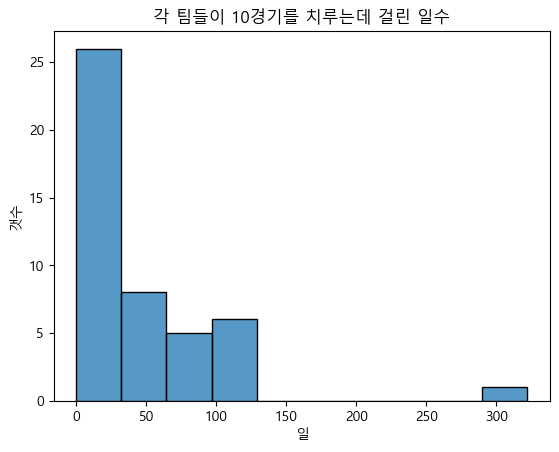

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
sns.histplot(list(count_dict.keys()), bins=10)
plt.xlabel('일')
plt.ylabel('갯수')
plt.title('각 팀들이 10경기를 치루는데 걸린 일수')
plt.show()

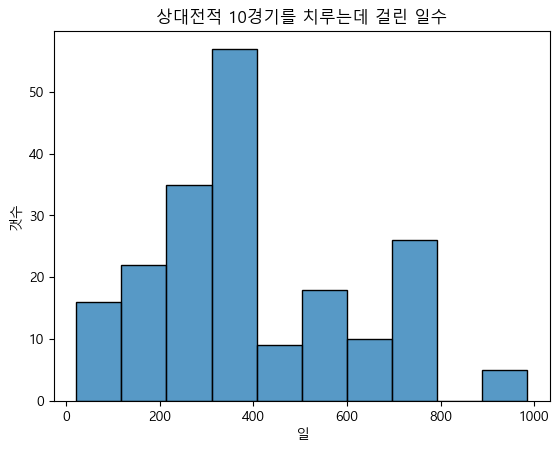

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
#headtohead_count_dict.pop(0)
sns.histplot(list(headtohead_count_dict.keys()), bins=10)
plt.xlabel('일')
plt.ylabel('갯수')
plt.title('상대전적 10경기를 치루는데 걸린 일수')
plt.show()

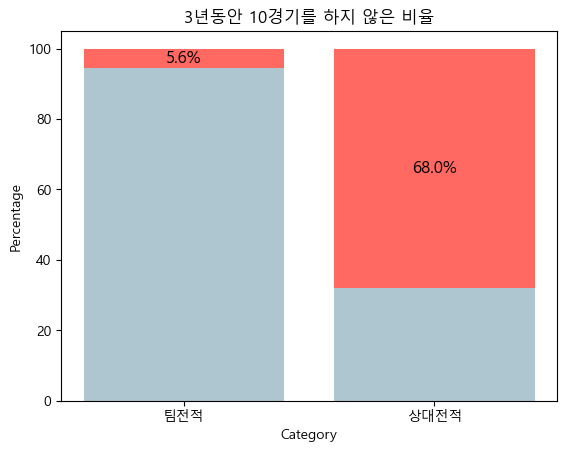

In [65]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
data = {
    'Category': ['팀전적', '상대전적'],
    'Total': [162, 1796],
    'Part': [9, 1222]
}

# Calculate the remaining parts
data['Remaining'] = [total - part for total, part in zip(data['Total'], data['Part'])]

# Normalize to percentages
data['Part_percentage'] = [part / total * 100 for part, total in zip(data['Part'], data['Total'])]
data['Remaining_percentage'] = [remaining / total * 100 for remaining, total in zip(data['Remaining'], data['Total'])]

# Create a DataFrame
df = pd.DataFrame(data)

# Set the colors for the stacked bars
colors = ['#AEC6CF', '#FF6961']  # Pastel blue for the base, vibrant red for the top

# Plot the first part (Remaining) as the base
plt.bar(df['Category'], df['Remaining_percentage'], color=colors[0])

# Plot the second part (Part) on top of the first part
bars = plt.bar(df['Category'], df['Part_percentage'], bottom=df['Remaining_percentage'], color=colors[1])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('3년동안 10경기를 하지 않은 비율')

# Annotate percentage on the red area
for bar, part_percentage in zip(bars, df['Part_percentage']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + height / 2,
        f'{part_percentage:.1f}%',
        ha='center',
        va='center',
        color='black',
        fontsize=12
    )

# Show the plot
plt.show()

In [3]:
dataset = pd.read_excel("../data/dataset.xlsx", dtype = {"gameId" : "str"}, index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7194 entries, 0 to 7193
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        7194 non-null   object 
 1   Blue_Adc_championDamageShare  7194 non-null   float64
 2   Blue_Adc_creepScorePerTime    7194 non-null   float64
 3   Blue_Adc_goldEarnedPerTime    7194 non-null   float64
 4   Blue_Adc_kda                  7194 non-null   float64
 5   Blue_Adc_wardsScorePerTime    7194 non-null   float64
 6   Blue_Jgl_championDamageShare  7194 non-null   float64
 7   Blue_Jgl_creepScorePerTime    7194 non-null   float64
 8   Blue_Jgl_goldEarnedPerTime    7194 non-null   float64
 9   Blue_Jgl_kda                  7194 non-null   float64
 10  Blue_Jgl_wardsScorePerTime    7194 non-null   float64
 11  Blue_Mid_championDamageShare  7194 non-null   float64
 12  Blue_Mid_creepScorePerTime    7194 non-null   float64
 13  Blue_Mid

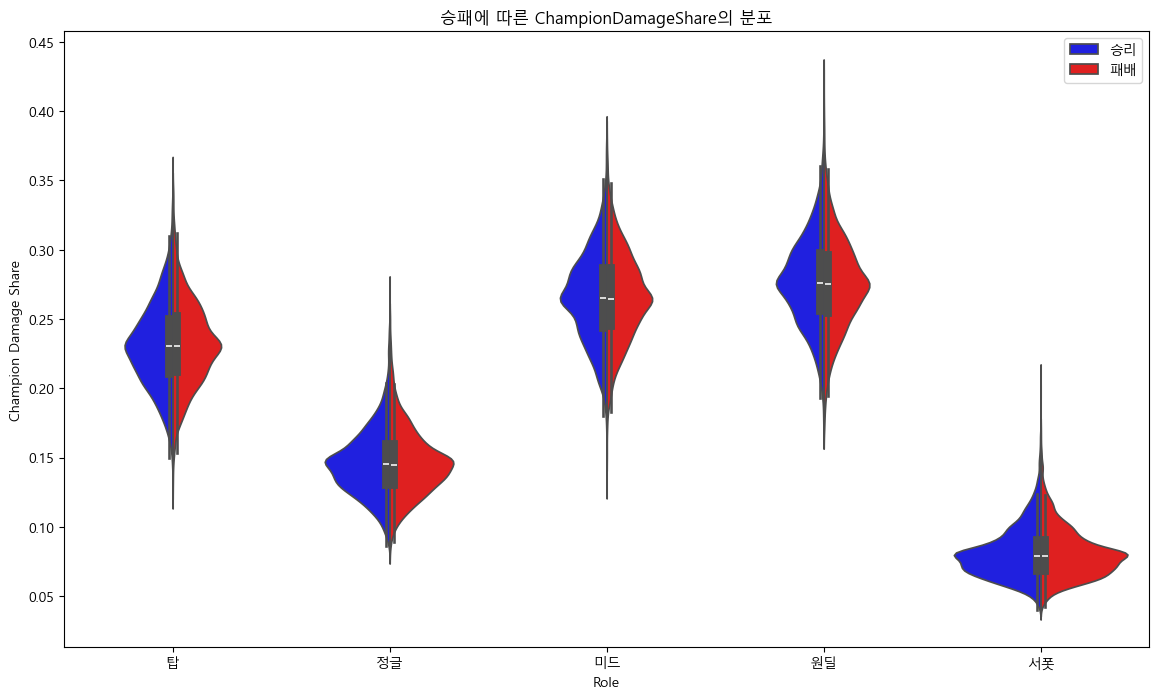

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
part_dataset = dataset[["Blue_Top_championDamageShare", "Blue_Jgl_championDamageShare", "Blue_Mid_championDamageShare", "Blue_Adc_championDamageShare", "Blue_Spt_championDamageShare", "winner"]]

# melt dataset to long format
melted_dataset = pd.melt(part_dataset, id_vars="winner", var_name="Role", value_name="DamageShare")

# rename columns
role_mapping = {
    "Blue_Top_championDamageShare": "탑",
    "Blue_Jgl_championDamageShare": "정글",
    "Blue_Mid_championDamageShare": "미드",
    "Blue_Adc_championDamageShare": "원딜",
    "Blue_Spt_championDamageShare": "서폿"
}
melted_dataset['Role'] = melted_dataset['Role'].map(role_mapping)
# Convert winner column to categorical type with specific order
melted_dataset['winner'] = pd.Categorical(melted_dataset['winner'], categories=["Blue", "Red"], ordered=True)

# boxplot 생성
plt.figure(figsize=(14, 8))
sns.violinplot(x="Role", y="DamageShare", hue="winner", data=melted_dataset, split=True, palette={"Blue": "blue", "Red": "red"})

# 그래프 설정 조정
plt.title("승패에 따른 ChampionDamageShare의 분포")
plt.xlabel("역할")
plt.ylabel("Champion Damage Share")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["승리", "패배"]
plt.legend(handles, labels)
plt.show()

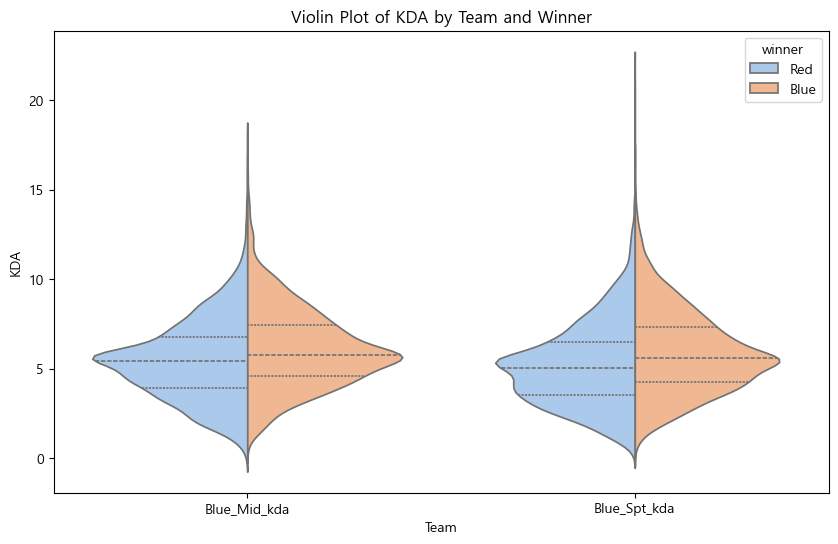

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
part_dataset = dataset[["Blue_Mid_kda", "Blue_Spt_kda", "winner"]]

melted_dataset = part_dataset.melt(id_vars="winner", var_name="Team", value_name="KDA")

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Team", y="KDA", hue="winner", data=melted_dataset, split=True, inner="quart", palette="pastel")

# Add titles and labels
plt.title('Violin Plot of KDA by Team and Winner')
plt.xlabel('Team')
plt.ylabel('KDA')

# Show the plot
plt.show()

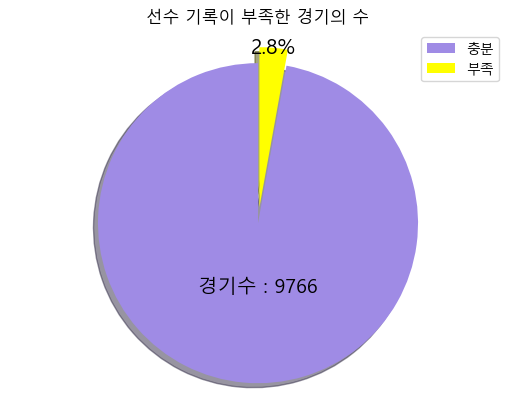

In [49]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
# Data
total = 9766
part = 278
remaining = total - part

# Colors
colors = ['#9F8BE5', '#FFFF00']  # #874CE6 for total part, bright yellow for the part

# Labels
#labels = [f'Total: {total}', f'Part: {part}']
labels = [f'Total: {total}', '']  # Only show label for tota

# Create a pie chart
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    [remaining, part], 
    colors=colors, 
    #labels=labels, 
    #autopct='%1.1f%%', 
    startangle=90,
    explode=(0, 0.1),  # Explode the part section slightly for emphasis
    shadow=True
)
# Annotate the part percentage on the pie chart
for i, wedge in enumerate(wedges):
    if i == 1:  # The part we want to annotate (the second slice)
        angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * 1.1 * np.cos(np.radians(angle))
        y = wedge.r * 1.1 * np.sin(np.radians(angle))
        ax.text(x, y, f'{part / total * 100:.1f}%', ha='center', va='center', color='black', fontsize=15)
        
plt.text(0, -0.4, f'경기수 : {total}', ha='center', va='center', fontsize=14, color='black')

# Set the aspect of the plot to be equal
ax.axis('equal')

# Set the title
plt.title('선수 기록이 부족한 경기의 수')
plt.legend(labels = ["충분", "부족"])

# Show the plot
plt.show()

In [70]:
dataset, scaler = joblib.load("../data/dataset_draft7_1.pkl")

In [79]:
kdadiff = dataset[["Blue_Top_killsPerTime", "Red_Top_killsPerTime", "Blue_Mid_killsPerTime", "Red_Mid_killsPerTime", "Blue_Adc_killsPerTime", "Red_Adc_killsPerTime"]]
kdadiff.describe()

,Blue_Top_killsPerTime,Red_Top_killsPerTime,Blue_Mid_killsPerTime,Red_Mid_killsPerTime,Blue_Adc_killsPerTime,Red_Adc_killsPerTime
count,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000
mean,-0.531795,-0.520480,0.162073,0.166566,0.889633,0.950747
std,0.898877,0.900159,1.114657,1.093440,1.268400,1.301868
min,-2.860579,-2.860579,-2.860579,-2.860579,-2.860579,-2.860579
25%,-1.179418,-1.185430,-0.649276,-0.638647,-0.055600,-0.041200
50%,-0.649876,-0.640351,0.015316,0.045594,0.814449,0.857530
75%,-0.007440,0.013714,0.820444,0.809127,1.691218,1.781966
max,4.403645,3.921882,6.281065,6.280400,9.564049,11.491818


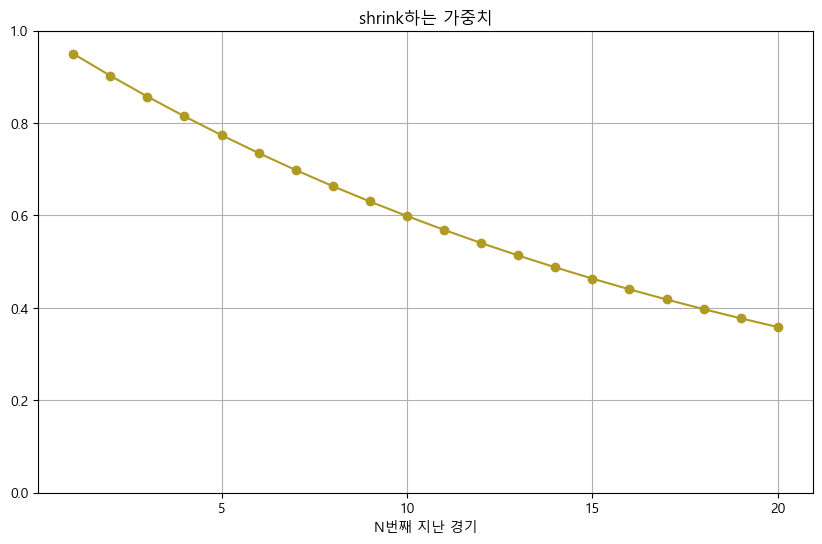

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x
x = np.arange(1, 21)

# Compute y values
y = 0.95 ** x

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='#AF9A23')
# Set y-axis limits
plt.ylim(0, 1)
# Set x-axis ticks
plt.xticks([5, 10, 15, 20])

# Add titles and labels
plt.title('shrink하는 가중치')
plt.xlabel('N번째 지난 경기')
#plt.ylabel('$0.95^x$')

# Show the plot
plt.grid(True)
plt.show()

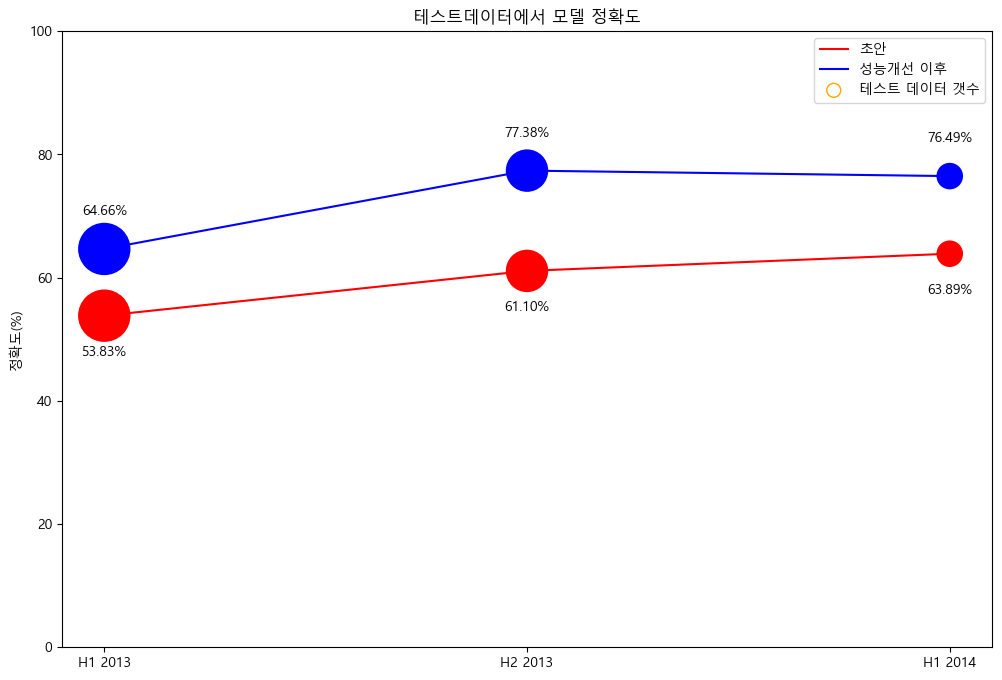

In [143]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'Category': ['H1 2013', 'H2 2013', 'H1 2014'],
    'Probability': [64.66, 77.38, 76.49],
    'SampleSize': [450, 367, 234]
}

# Additional probabilities
additional_probs = [53.83, 61.10, 63.89]

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize sample size for point sizes
norm_sample_size = (df['SampleSize'] ** 2) / max(df['SampleSize'] ** 2) * 1500  # Adjust the multiplier for appropriate size

# Create the plot
plt.figure(figsize=(12, 8))

# Add the additional probabilities as a dashed line
plt.plot(df['Category'], additional_probs, marker='', linestyle='-', color='r', label='초안')

# Plot the additional probabilities as scatter points with sizes based on squared sample sizes
plt.scatter(df['Category'], additional_probs, s=norm_sample_size, color='r', alpha=1, edgecolors='w')

# Plot the main probabilities as a line
plt.plot(df['Category'], df['Probability'], marker='', linestyle='-', color='b', label='성능개선 이후')

# Plot the main probabilities as scatter points with sizes based on squared sample sizes
plt.scatter(df['Category'], df['Probability'], s=norm_sample_size, color='b', alpha=1, edgecolors='w')



# Add titles and labels
plt.title('테스트데이터에서 모델 정확도')
#plt.xlabel('Category')
plt.ylabel('정확도(%)')
plt.ylim(0, 100)

# Annotate points with probability values for the main probabilities
for x, y in zip(df['Category'], df['Probability']):
    plt.text(x, y + 5, f'{y:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Annotate points with probability values for the additional probabilities
for x, y in zip(df['Category'], additional_probs):
    plt.text(x, y - 7, f'{y:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Add custom legend entry for sample sizes
plt.scatter([], [], s=100, facecolors='none', edgecolors='orange', label='테스트 데이터 갯수')

# Add legend
plt.legend()

# Show the plot
plt.show()
